In [25]:
# Import libraries and cleaned seismic data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

seismic_data = pd.read_csv('cleaned_seismic.csv')
print(seismic_data.columns)
seismic_data.head()

Index(['Seismic Zone', 'PGA (m/s²)', 'PGV (m/s)', 'PGD (m)',
       'Spectral Acceleration (g)', 'Soil Type', 'Site Amplification Factor',
       'Historical Earthquake Magnitude (Mw)', 'Fault Distance (km)',
       'Seismic Wave Frequency (Hz)', 'Building Height (m)',
       'Number of Stories', 'Structural Material', 'Foundation Type',
       'Natural Frequency (Hz)', 'Damping Ratio (%)', 'Mass of Structure (kg)',
       'Axial Stiffness (kN/m)', 'Bending Stiffness (kN·m²)',
       'Lateral Load Resisting System',
       'Predicted Max Inter-Story Drift Ratio (%)',
       'Predicted Max Roof Displacement (m)',
       'Predicted Base Shear Force (kN)',
       'Predicted Structural Acceleration (m/s²)',
       'Predicted Damage Index (0–1 Scale)',
       'Predicted Collapse Probability (%)', 'damage_index', 'collapse_prob',
       'collapse_risk'],
      dtype='object')


,Seismic Zone,PGA (m/s²),PGV (m/s),PGD (m),Spectral Acceleration (g),Soil Type,Site Amplification Factor,Historical Earthquake Magnitude (Mw),Fault Distance (km),Seismic Wave Frequency (Hz),...,Lateral Load Resisting System,Predicted Max Inter-Story Drift Ratio (%),Predicted Max Roof Displacement (m),Predicted Base Shear Force (kN),Predicted Structural Acceleration (m/s²),Predicted Damage Index (0–1 Scale),Predicted Collapse Probability (%),damage_index,collapse_prob,collapse_risk
0,0,-1.024996,-1.345436,-1.315178,-0.630563,2,-1.496834,0.152099,-0.988449,-1.205958,...,1,-0.271670,-0.297741,0.980711,-1.210012,1.025903,1.025903,0.420436,42.043614,Medium
1,3,1.366249,0.395868,-0.293547,1.589930,0,-1.256734,0.116608,-1.541292,-0.379265,...,1,0.256804,0.904280,0.279565,-0.454989,0.682046,0.682046,0.278620,27.862026,Low
2,1,-0.719795,-0.751395,1.362875,-1.598828,1,1.293235,0.326603,-0.589064,0.251655,...,1,0.174554,-0.373931,-1.635784,1.367002,0.994694,0.994694,0.207459,20.745906,Low
3,0,-0.441647,-1.128431,-1.541503,0.285596,1,0.504215,0.924160,-1.241326,1.528933,...,0,0.316621,0.509345,1.126275,0.900256,0.893567,0.893567,0.234376,23.437582,Low
4,0,-1.513362,-0.405390,1.622573,-1.139836,1,-0.830620,1.674861,0.790074,-1.522297,...,0,-1.187317,0.884650,-1.114634,-0.726078,-1.073633,-1.073633,0.318586,31.858630,Medium


## Feature Selection

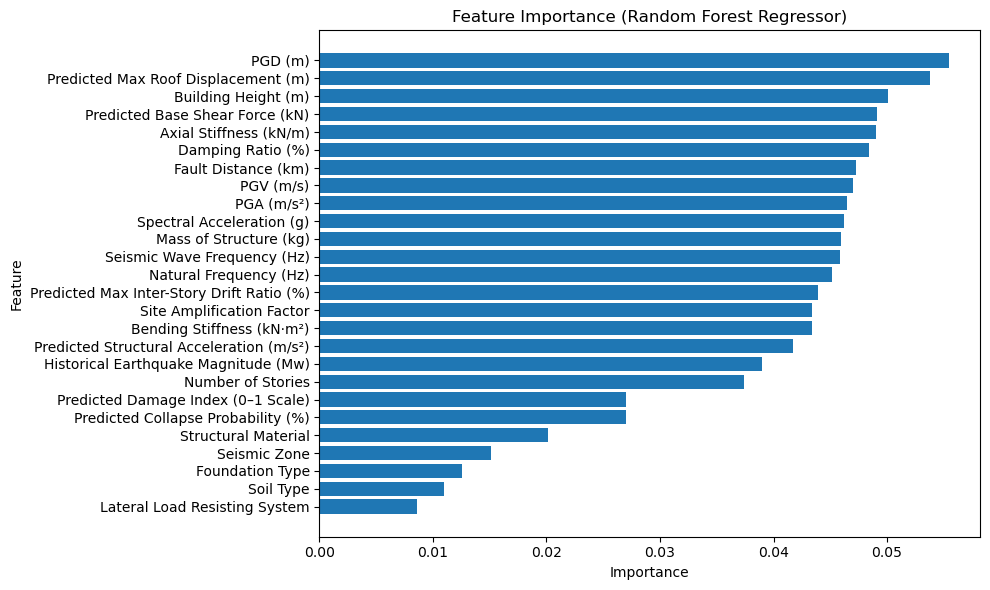

,Site Amplification Factor,Predicted Max Inter-Story Drift Ratio (%),Natural Frequency (Hz),Seismic Wave Frequency (Hz),Mass of Structure (kg),Spectral Acceleration (g),PGA (m/s²),PGV (m/s),Fault Distance (km),Damping Ratio (%),Axial Stiffness (kN/m),Predicted Base Shear Force (kN),Building Height (m),Predicted Max Roof Displacement (m),PGD (m)
0,-1.496834,-0.271670,-0.428828,-1.205958,0.755228,-0.630563,-1.024996,-1.345436,-0.988449,-0.949964,-0.773111,0.980711,-1.132741,-0.297741,-1.315178
1,-1.256734,0.256804,-0.121766,-0.379265,-1.697095,1.589930,1.366249,0.395868,-1.541292,-1.397465,-0.737852,0.279565,-1.715854,0.904280,-0.293547
2,1.293235,0.174554,-1.709644,0.251655,0.637837,-1.598828,-0.719795,-0.751395,-0.589064,-0.235300,0.845199,-1.635784,0.921923,-0.373931,1.362875
3,0.504215,0.316621,-0.342863,1.528933,1.487787,0.285596,-0.441647,-1.128431,-1.241326,-1.302925,-1.650833,1.126275,1.281235,0.509345,-1.541503
4,-0.830620,-1.187317,-0.127321,-1.522297,0.719874,-1.139836,-1.513362,-0.405390,0.790074,-0.221809,-0.414168,-1.114634,0.373211,0.884650,1.622573


In [27]:
# Determine which features of seismic_data are most relevant to predicting collapse_prob

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Define features and target variable
X = seismic_data.drop(columns=['damage_index', 'collapse_prob',
       'collapse_risk'])
y = seismic_data['collapse_prob']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Regressor
rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=True)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Random Forest Regressor)')
plt.tight_layout()
plt.show()

# Select top N features based on importance and create a new dataset with these features for further modeling
top_n = 15
top_features = importance_df['Feature'].tail(top_n).values
X_top = X[top_features]
X_top.head()



## Logistic Regression Model

Cross-validation accuracy scores: [0.37142857 0.31428571 0.4        0.38571429 0.38571429 0.35714286
 0.34285714 0.37142857 0.44285714 0.41428571]
Mean CV accuracy: 0.3785714285714286
[[16  9 72]
 [10 13 73]
 [22 12 73]]
              precision    recall  f1-score   support

        High       0.33      0.16      0.22        97
         Low       0.38      0.14      0.20        96
      Medium       0.33      0.68      0.45       107

    accuracy                           0.34       300
   macro avg       0.35      0.33      0.29       300
weighted avg       0.35      0.34      0.30       300



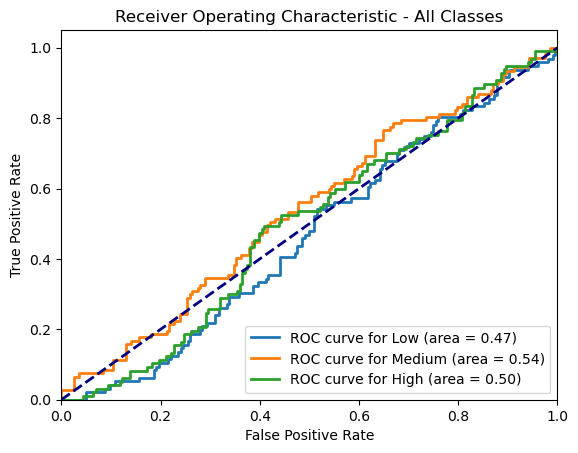

In [30]:
# Create and evaluate a logistic regression model using the selected features to predict collapse risk

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = seismic_data[top_features]
y = seismic_data['collapse_risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(max_iter=10000)

# Perform k-fold cross-validation (e.g., k=5)
cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
print(f'Cross-validation accuracy scores: {cv_scores}')
print(f'Mean CV accuracy: {cv_scores.mean()}')

# Fit and evaluate on test set
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot ROC Curve for all classes
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

classes = ['Low', 'Medium', 'High']
y_test_bin = label_binarize(y_test, classes=classes)
y_prob = model.predict_proba(X_test)

plt.figure()
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve for {class_name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - All Classes')
plt.legend(loc="lower right")
plt.show()

## Random Forest Regressor

In [13]:
# Random Forest Regressor Model to predict collapse probability

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = seismic_data[top_features]
y = seismic_data['collapse_prob']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')


Mean Squared Error: 913.1458490028189
R² Score: -0.0017115504574944929


## SVR

In [14]:
# Support Vector Regressor (SVR) Model to predict collapse probability

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

X = seismic_data[top_features]
y = seismic_data['collapse_prob']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')



Mean Squared Error: 1134.973882211015
R² Score: -0.24505460822047476


In [34]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Scale features for SVR
scaler = StandardScaler()
X_scaled = scaler.fit_transform(seismic_data[top_features])
y = seismic_data['collapse_prob']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define parameter grid
param_grid = {
    'C': [50, 75, 100, 125, 150,],
    'gamma': [0.75, 1, 1.25, 1.5],
    'epsilon': [0.075, 0.1, 0.125],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

# Grid search
grid = GridSearchCV(SVR(), param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

# Evaluate best model
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Best parameters: {'C': 75, 'epsilon': 0.125, 'gamma': 1.5, 'kernel': 'rbf'}
Mean Squared Error: 914.1892053897338
R² Score: -0.0028561016210983947


In [46]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(seismic_data[top_features])
y = seismic_data['collapse_prob']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ridge Regression Grid Search
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_grid.fit(X_train, y_train)
print("Best Ridge parameters:", ridge_grid.best_params_)
ridge_best = ridge_grid.best_estimator_
y_pred = ridge_best.predict(X_test)
print(f'Ridge MSE: {mean_squared_error(y_test, y_pred)}')
print(f'Ridge R² Score: {r2_score(y_test, y_pred)}')

# Lasso Regression Grid Search
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(Lasso(), lasso_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_grid.fit(X_train, y_train)
print("Best Lasso parameters:", lasso_grid.best_params_)
lasso_best = lasso_grid.best_estimator_
y_pred = lasso_best.predict(X_test)
print(f'Lasso MSE: {mean_squared_error(y_test, y_pred)}')
print(f'Lasso R² Score: {r2_score(y_test, y_pred)}')

Best Ridge parameters: {'alpha': 100}
Ridge MSE: 931.6993863679594
Ridge R² Score: -0.03875681276561238
Best Lasso parameters: {'alpha': 10}
Lasso MSE: 900.009569035616
Lasso R² Score: -0.0034256596802877404


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

X = seismic_data[top_features]
y = seismic_data['collapse_prob']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
print("Best RF parameters:", rf_grid.best_params_)
rf_best = rf_grid.best_estimator_
y_pred = rf_best.predict(X_test)
print(f'RF MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RF R² Score: {r2_score(y_test, y_pred)}')

Best RF parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
RF MSE: 910.3750176418674
RF R² Score: 0.0013280228830250262
